In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import os
from comet_ml import Experiment

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
sns.set_theme()

from ift6758.models.utils import preprocess, predict_model,save_metrics_and_models_on_comet
from ift6758.models.plotter import *
from dotenv import load_dotenv

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import time

from comet_ml import API


In [2]:
url = 'https://drive.google.com/file/d/1kM__riNHRPx5GsyuOH3yhiql3OZvwmuP/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)

In [3]:
df_train = df[df['season']!=20192020]

## question 5.1

In [4]:
# preprocess
X, Y ,df_train_preprocessed =  preprocess(df_train,features = ['distance','angle'], standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True, stratify=Y)

# define and train model
model = XGBClassifier()

# fit_model
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/princesslove/itf-6758-team-4/26c1288910b24f8f9c59b91f13374957

COMET WARNING: Converting metric value ''question5.1'' into a string using str(), resulting string might be invalid
COMET INFO: Successfully registered 'question5-1-model', version '1.0.0' in workspace 'princesslove'


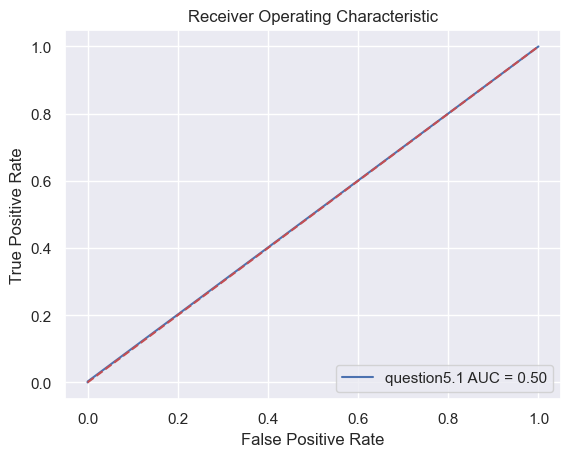

<Figure size 640x480 with 0 Axes>

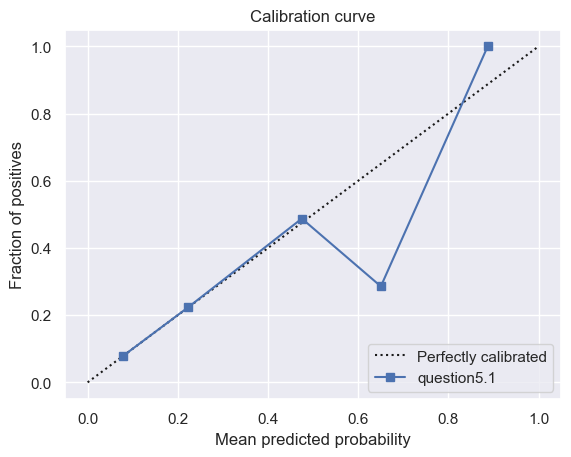

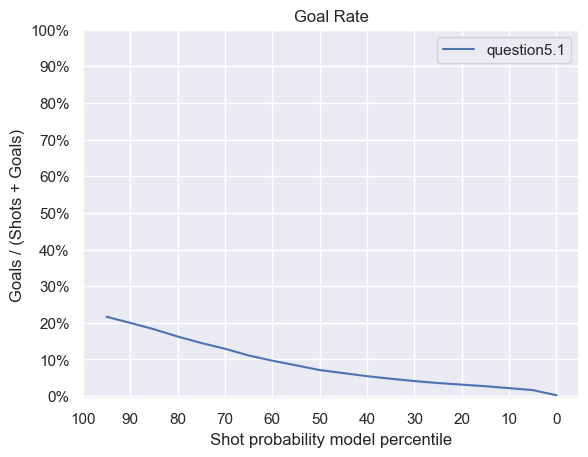

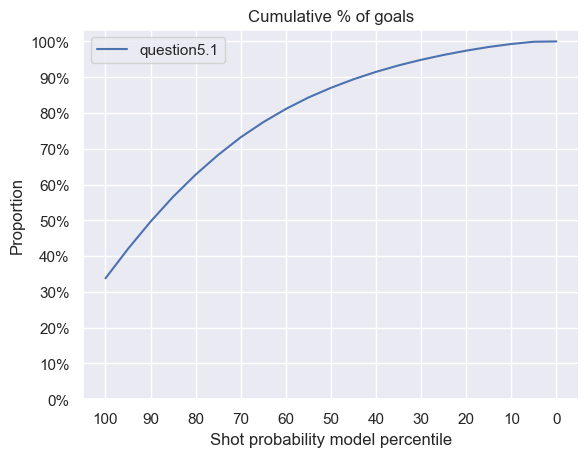

In [5]:
name_experiment = "question5.1"
model_dir = "XGB"

save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment)

## question 5.2

In [6]:
list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

# preprocess
X, Y ,df_train_preprocessed =  preprocess(df_train,features = list_features, standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True,stratify=Y)

# define and train model
model = XGBClassifier()

# fit_model
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

COMET WARNING: You must install graphviz to plot tree


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/26c1288910b24f8f9c59b91f13374957
COMET INFO:   Metrics:
COMET INFO:     AUC        : 0.5013013732212985
COMET INFO:     Accuracy   : 0.906195174756436
COMET INFO:     Precision  : 0.6976589257949748
COMET INFO:     Recall     : 0.5013013732212985
COMET INFO:     f_score    : 0.4782889055761102
COMET INFO:     model_name : question5.1
COMET INFO:   Others:
COMET INFO:     Name : question5.1
COMET INFO:   Parameters:
COMET INFO:     begin_iteration : 0
COMET INFO:     copy            : True
COMET INFO:     end_iteration   : 99
COMET INFO:     objective       : binary:logistic
COMET INFO:     rank            : 0
COMET INFO:     with_mean       : True
COMET INFO:     with_std        : True
COMET INFO:     world_size      

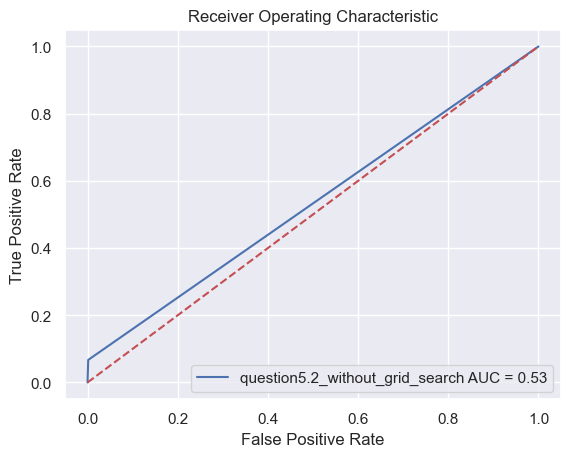

<Figure size 640x480 with 0 Axes>

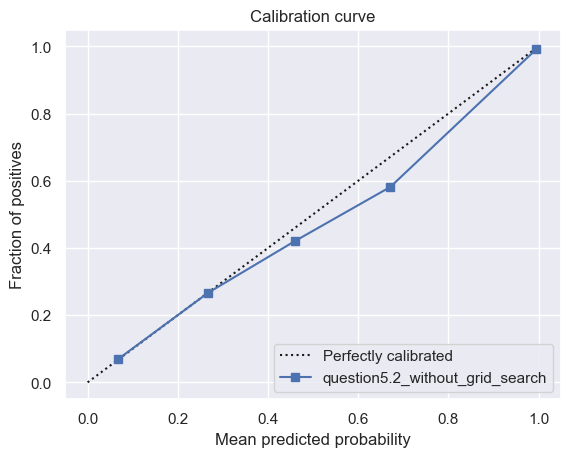

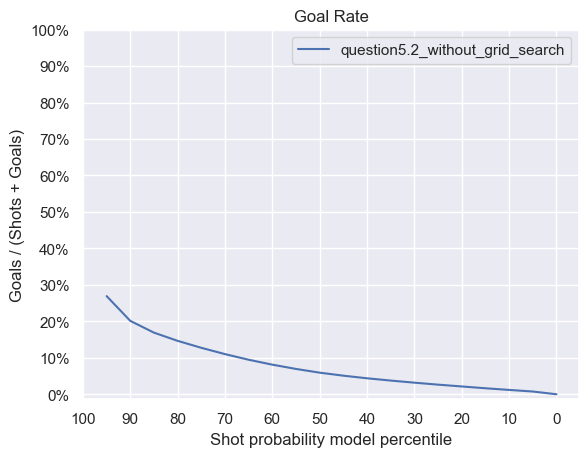

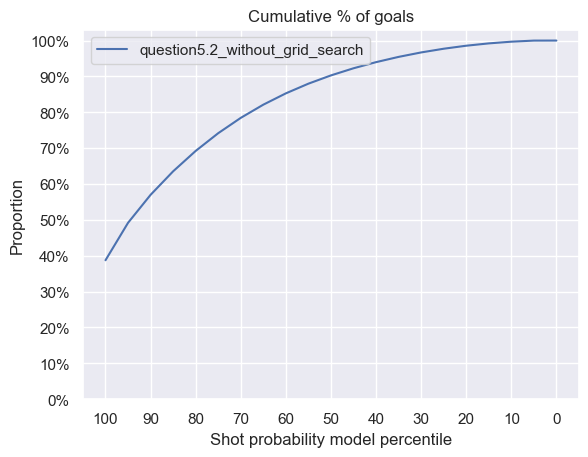

In [7]:
name_experiment = "question5.2_without_grid_search"
model_dir = "XGB"

save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment)

## question 5.2 Performing Cross Validation Grid Search with all features

In [8]:
#setting grid of selected parameters for iteration
'''
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'max_delta_step' : [1,2,3,4,5,6,7,8,9,10],
              'min_child_weight': [1, 5, 10],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            #'lambda':[0.4, 0.6,0.8,1],
            #'alpha':[0, 0.2,0.4,0.6],
            }
'''

param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


In [9]:
# question 5.2

list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']

# preprocess
X, Y ,df_train_preprocessed =  preprocess(df_train,features = list_features, standarize=True)

# train/test split
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True,stratify=Y)


In [10]:
# define and train model
model = XGBClassifier(learning_rate=0.02,\
                        n_estimators=600,\
                        objective='binary:logistic',\
                        #silent=True,
                        scale_pos_weight = np.sum(y_train)/len(y_train),
                        predictor='cpu_predictor',
                        #num_parallel_tree=3,
                        tree_method = 'hist',
                        max_bin=250)

In [11]:
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=param_comb, scoring='f1_macro', n_jobs=-1, cv=skf, verbose=3, random_state=42 )

# Here we go
start_time = time.time() # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
print(time.time() - start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.527 total time=  35.2s
[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.521 total time=  36.2s
[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.525 total time=  36.2s
[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.521 total time=  36.2s
[CV 3/5] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.521 total time=  28.5s
[CV 2/5] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.525 total time=  28.5s
[CV 1/5] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.521 total time=  28.6s
[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=4, m

In [12]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results


 All results:
{'mean_fit_time': array([33.78701377, 26.39576483, 25.09789076, 29.43696079, 30.59699697]), 'std_fit_time': array([1.27925298, 1.58789614, 0.88963463, 0.77034438, 6.08988175]), 'mean_score_time': array([1.45655174, 0.87782159, 1.0974977 , 1.26517963, 1.00295458]), 'std_score_time': array([0.25885638, 0.01502052, 0.30744493, 0.22037189, 0.24791725]), 'param_subsample': masked_array(data=[0.8, 1.0, 0.8, 0.6, 0.6],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[10, 1, 10, 10, 10],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[4, 3, 3, 3, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[1.5, 2, 5, 1, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
     

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_min_child_weight,param_max_depth,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,33.787014,1.279253,1.456552,0.258856,0.8,10,4,1.5,0.6,"{'subsample': 0.8, 'min_child_weight': 10, 'ma...",0.521476,0.524774,0.521062,0.527439,0.522937,0.523538,0.002345,1
1,26.395765,1.587896,0.877822,0.015021,1.0,1,3,2,0.8,"{'subsample': 1.0, 'min_child_weight': 1, 'max...",0.521476,0.524774,0.521062,0.527439,0.522937,0.523538,0.002345,1
2,25.097891,0.889635,1.097498,0.307445,0.8,10,3,5,1.0,"{'subsample': 0.8, 'min_child_weight': 10, 'ma...",0.521476,0.524774,0.521062,0.527439,0.522937,0.523538,0.002345,1
3,29.436961,0.770344,1.265180,0.220372,0.6,10,3,1,0.6,"{'subsample': 0.6, 'min_child_weight': 10, 'ma...",0.521476,0.523746,0.521062,0.526620,0.522524,0.523086,0.001997,4
4,30.596997,6.089882,1.002955,0.247917,0.6,10,4,1,0.6,"{'subsample': 0.6, 'min_child_weight': 10, 'ma...",0.521476,0.523540,0.520855,0.527030,0.522524,0.523085,0.002175,5


In [14]:
results.to_csv('../models_config/XGB/xgb-random-grid-search-results-01.csv', index=False)

In [15]:
model.set_params(**random_search.best_params_)
# fit model 
model.fit(X_train,y_train)
y_val_pred,y_val_prob = predict_model(model,X_val)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/4fc00eb8307d4fa9a3b1a35195cc7834
COMET INFO:   Metrics:
COMET INFO:     AUC        : 0.5328081064498501
COMET INFO:     Accuracy   : 0.9111348903184063
COMET INFO:     Precision  : 0.8666281698314976
COMET INFO:     Recall     : 0.5328081064498501
COMET INFO:     f_score    : 0.5386519305832189
COMET INFO:     model_name : question5.2_without_grid_search
COMET INFO:   Others:
COMET INFO:     Name : question5.2_without_grid_search
COMET INFO:   Parameters:
COMET INFO:     begin_iteration                    : 0
COMET INFO:     colsample_bytree                   : 0.6
COMET INFO:     copy                               : True
COMET INFO:     cv                                 : StratifiedKFold(n_splits=5, random_state=42,

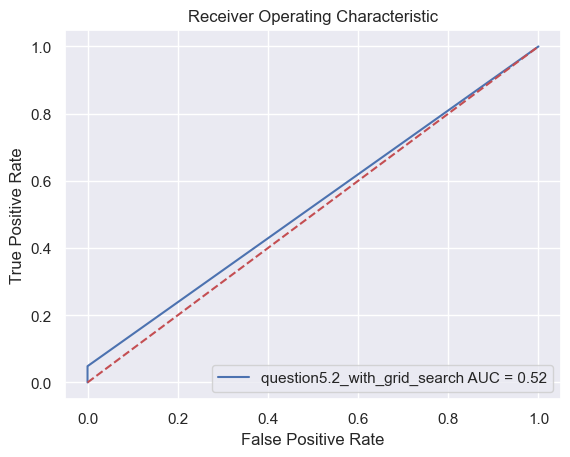

<Figure size 640x480 with 0 Axes>

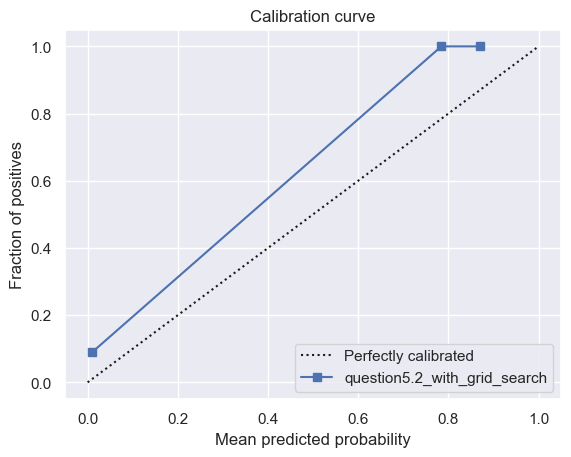

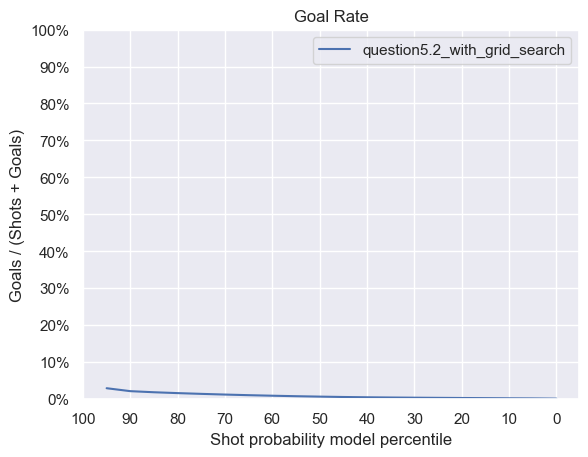

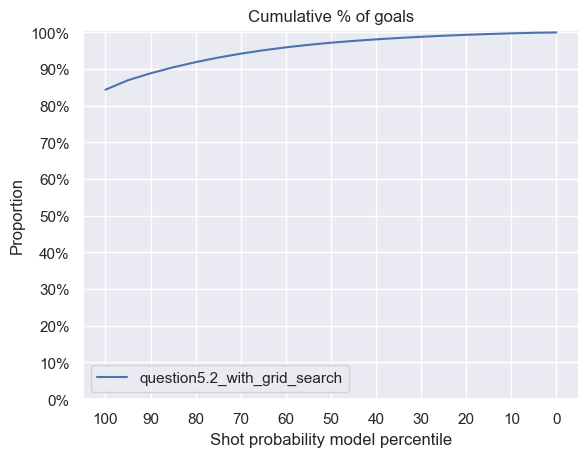

In [16]:
name_experiment = "question5.2_with_grid_search"
model_dir = "XGB"

save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob,model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment)

## Exploring XGboost feature importance with SHAP

In [ ]:
# get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [ ]:
# faire la suite avec les categorical features
cf le site

In [ ]:
Heatmap 

+ 

train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

## Performing some features selection

In [ ]:
# Faire les trucs du lab + inference ??

In [ ]:
sequential Feed forward (forward et backward)

In [ ]:
# LASSO
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

In [ ]:
clf.feature_importances_  
array([ 0.04...,  0.05...,  0.4...,  0.4...])
>>> model = SelectFromModel(clf, prefit=True)

In [ ]:
SelectKBest (avec f score)

In [ ]:
PCA (avec la courbe de variance pour connaitre le nombre dee features à séléctionner)

In [ ]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)